In [1]:
import numpy as np
import pandas as pd
import earthscopestraintools
import math
import importlib
from importlib.resources import files
importlib.reload(earthscopestraintools)
from earthscopestraintools.tiledbtools import RawStrainWriter, RawStrainReader
from earthscopestraintools.mseed_tools import load_mseed_to_df, mseed2pandas
from earthscopestraintools.gtsm_metadata import GtsmMetadata
from earthscopestraintools.timeseries import ts_from_mseed, Timeseries
from earthscopestraintools.processing import decimate_1s_to_300s, butterworth_filter, interpolate, linearize
from earthscopestraintools.event import Earthquake
from earthscopestraintools.event_processing import calc_hypocentral_dist, magnitude_plot, plot_coseismic_offset
from datetime import datetime, timedelta

import logging
logger = logging.getLogger()
logging.basicConfig(
        format="%(message)s", level=logging.INFO
    )

In [2]:
network = 'IV'
station = 'TSM3'
meta = GtsmMetadata(network,station)

In [3]:
eq = Earthquake(event_id = "us7000jiky")
#eq = Earthquake(event_id = "us7000jiim")
hypocentral_distance = calc_hypocentral_dist(eq.lat,
                                                 eq.long,
                                                 eq.depth,
                                                 meta.latitude,
                                                 meta.longitude)
print(f"USGS Magnitude {eq.mag} at {hypocentral_distance} km at {eq.time}") 
meta.get_event_terms()

USGS Magnitude 4.6 at 15 km at 2023-03-09 19:08:07.085000+00:00


Loading T0 BS* from 2023-03-09T19:07:52 to 2023-03-09T19:09:07 from IRIS DMC miniseed
    Trace 1. 2023-03-09T19:07:52.000000Z:2023-03-09T19:09:07.000000Z mapping BS1 to CH0
    Trace 2. 2023-03-09T19:07:52.000000Z:2023-03-09T19:09:07.000000Z mapping BS2 to CH1
    Trace 3. 2023-03-09T19:07:52.000000Z:2023-03-09T19:09:07.000000Z mapping BS3 to CH2
    Trace 4. 2023-03-09T19:07:52.000000Z:2023-03-09T19:09:07.000000Z mapping BS4 to CH3
    Found 0 epochs with nans, 17.75 epochs with 999999s, and 0 missing epochs.
    Total missing data is 1.18%
Converting missing data from 999999 to nan
    Found 17 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 1.13%
IV.TSM3.T0.BS*
    | Channels: ['CH0', 'CH1', 'CH2', 'CH3']             
    | TimeRange: 2023-03-09 19:07:52 - 2023-03-09 19:09:07        | Period:          0.05s
    | Series:         raw| Units:        counts| Level:          0| Gaps:            1.13% 
    | Epochs:        1501| Good:        14

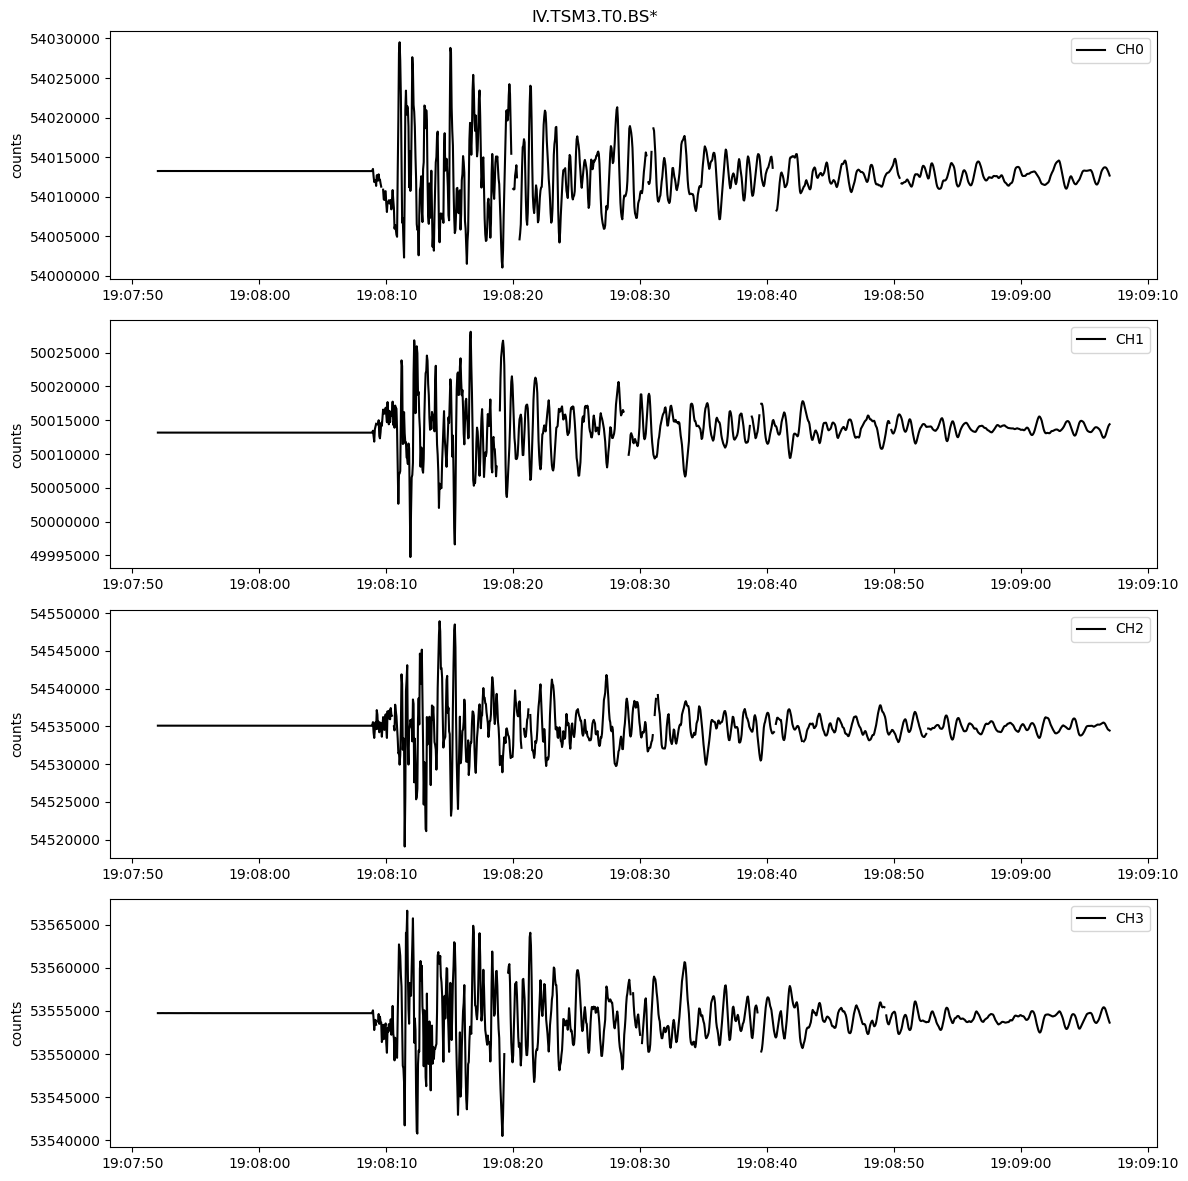

In [4]:
period = 20
start = (eq.time - timedelta(seconds=15)).strftime("%Y-%m-%dT%H:%M:%S")
end = (eq.time + timedelta(seconds=60)).strftime("%Y-%m-%dT%H:%M:%S")
ts1 = ts_from_mseed(network=network, station=station, location='T0', channel='BS*', start=start, end=end)
ts1.stats()
ts1.plot(type='line')

In [5]:
ts2 = ts1.linearize(reference_strains=meta.reference_strains, gap=meta.gap)
ts2.stats()


Converting raw counts to microstrain
    Found 17 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 1.13%
IV.TSM3.T0.BS*.linearized
    | Channels: ['CH0', 'CH1', 'CH2', 'CH3']             
    | TimeRange: 2023-03-09 19:07:52 - 2023-03-09 19:09:07        | Period:          0.05s
    | Series: microstrain| Units:   microstrain| Level:          1| Gaps:            1.13% 
    | Epochs:        1501| Good:        1483.25| Missing:    17.75| Interpolated:      0.0
    | Samples:       6004| Good:           5933| Missing:       71| Interpolated:        0


In [6]:
ts3 = ts2.interpolate(method='linear', limit_seconds=3600)
ts3.stats()
#ts3.plot(type='line')

Interpolating data using method=linear and limit=72000
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
IV.TSM3.T0.BS*.linearized.interpolated
    | Channels: ['CH0', 'CH1', 'CH2', 'CH3']             
    | TimeRange: 2023-03-09 19:07:52 - 2023-03-09 19:09:07        | Period:          0.05s
    | Series: microstrain| Units:   microstrain| Level:          1| Gaps:             0.0% 
    | Epochs:        1501| Good:        1483.25| Missing:      0.0| Interpolated:    17.75
    | Samples:       6004| Good:           5933| Missing:        0| Interpolated:       71


Applying Butterworth Filter
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
IV.TSM3.T0.BS*.linearized.interpolated.filtered
    | Channels: ['CH0', 'CH1', 'CH2', 'CH3']             
    | TimeRange: 2023-03-09 19:07:52 - 2023-03-09 19:09:07        | Period:          0.05s
    | Series:            | Units:   microstrain| Level:          1| Gaps:             0.0% 
    | Epochs:        1501| Good:        1483.25| Missing:      0.0| Interpolated:    17.75
    | Samples:       6004| Good:           5933| Missing:        0| Interpolated:       71


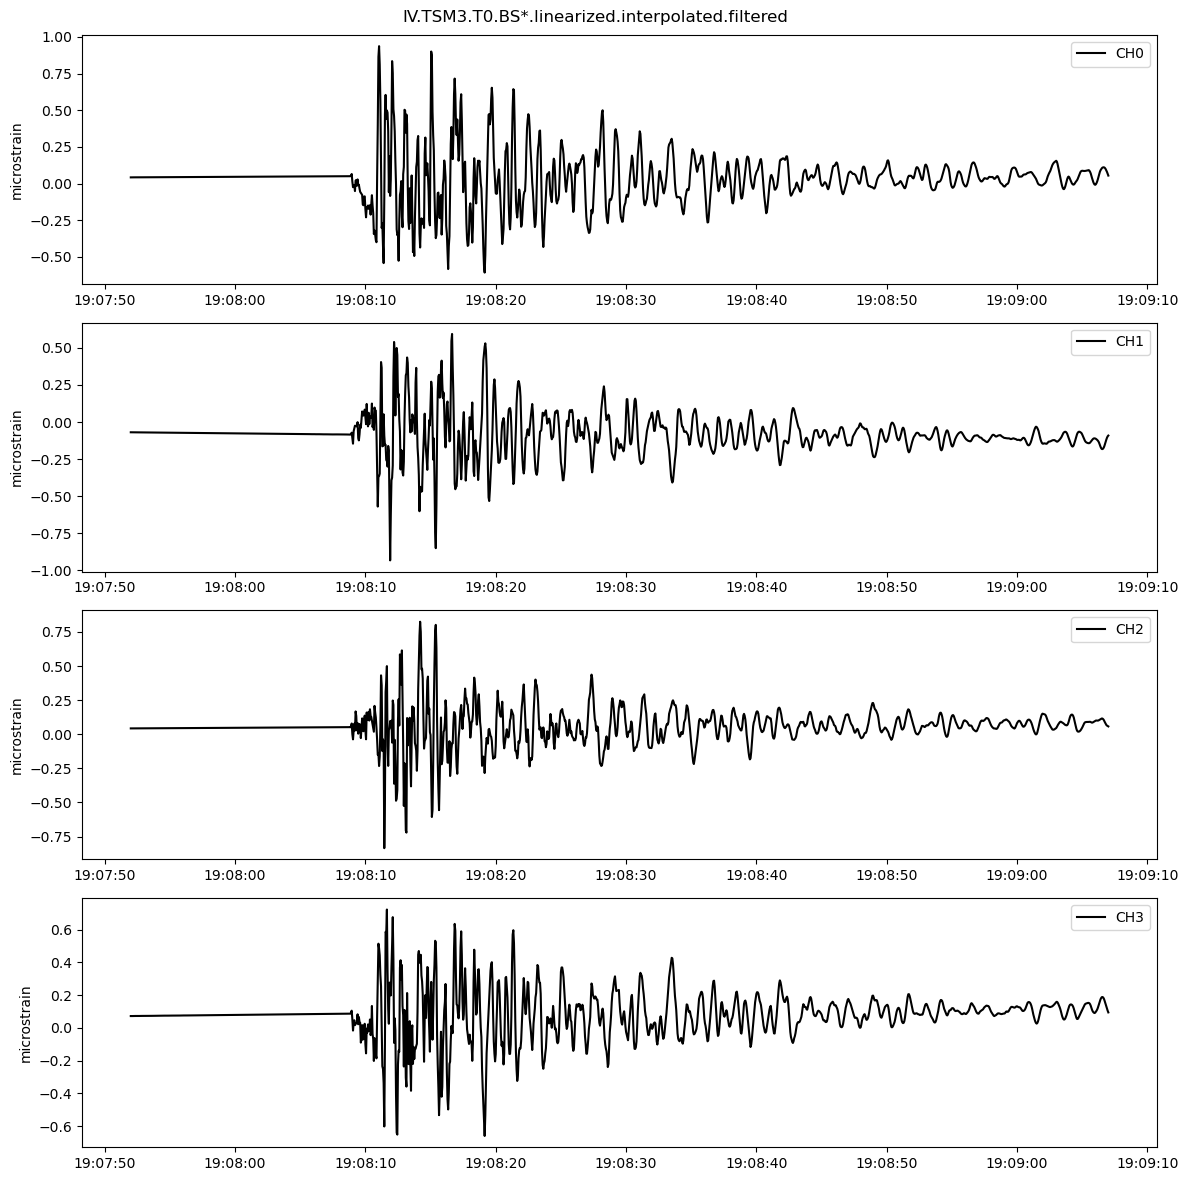

In [7]:
ts4 = ts3.butterworth_filter(filter_type='high', filter_order=2, filter_cutoff_s=1000)
ts4.stats()
ts4.plot(type='line')

Calculating dynamic strain using gauge weights: [1, 1, 1, 1]
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
IV.TSM3.T0.BS*.linearized.interpolated.filtered.dynamic
    | Channels: ['dynamic']                              
    | TimeRange: 2023-03-09 19:07:52 - 2023-03-09 19:09:07        | Period:          0.05s
    | Series:     dynamic| Units:   microstrain| Level:          1| Gaps:             0.0% 
    | Epochs:        1501| Good:         1435.0| Missing:      0.0| Interpolated:     66.0
    | Samples:       1501| Good:           1435| Missing:        0| Interpolated:       66


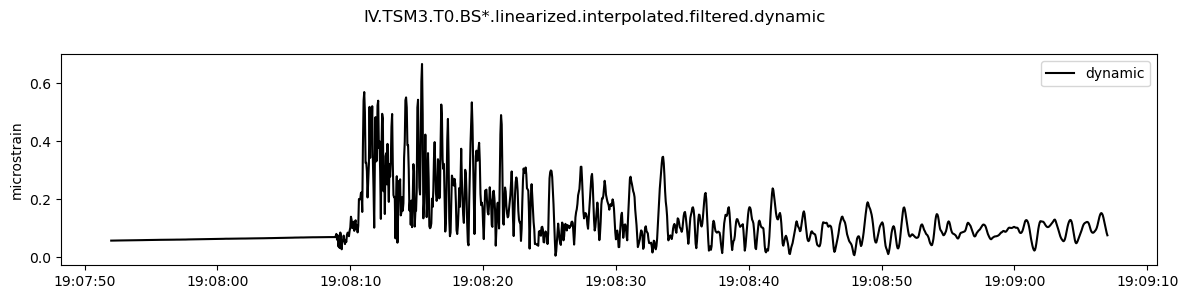

In [8]:
ts5 = ts4.dynamic_strain()
ts5.stats()
ts5.plot(type='line')

Calculating magnitude from dynamic strain using site term 0 and longitude term 0
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%


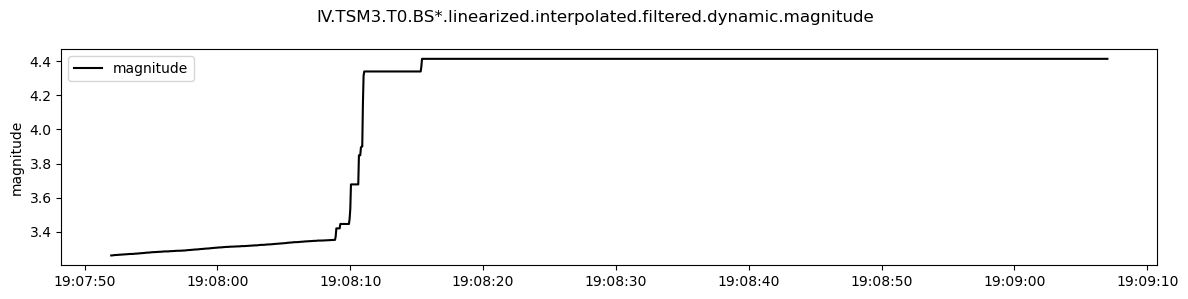

In [9]:
ts6 = ts5.calculate_magnitude(hypocentral_distance, meta.site_term, meta.longitude_term)
ts6.plot()

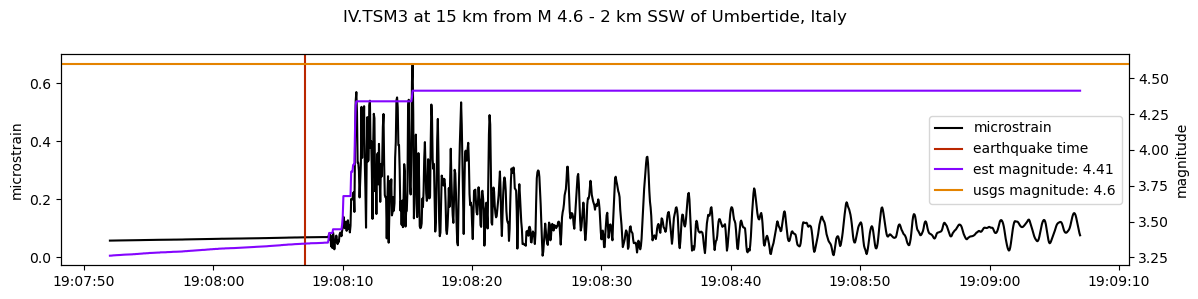

In [10]:
title = f"{network}.{station} at {hypocentral_distance} km from {eq.name}"
magnitude_plot(dynamic_strain_df=ts5.data, 
               magnitude_df=ts6.data, 
               eq_time=eq.time, 
               eq_mag=eq.mag, 
               title=title)

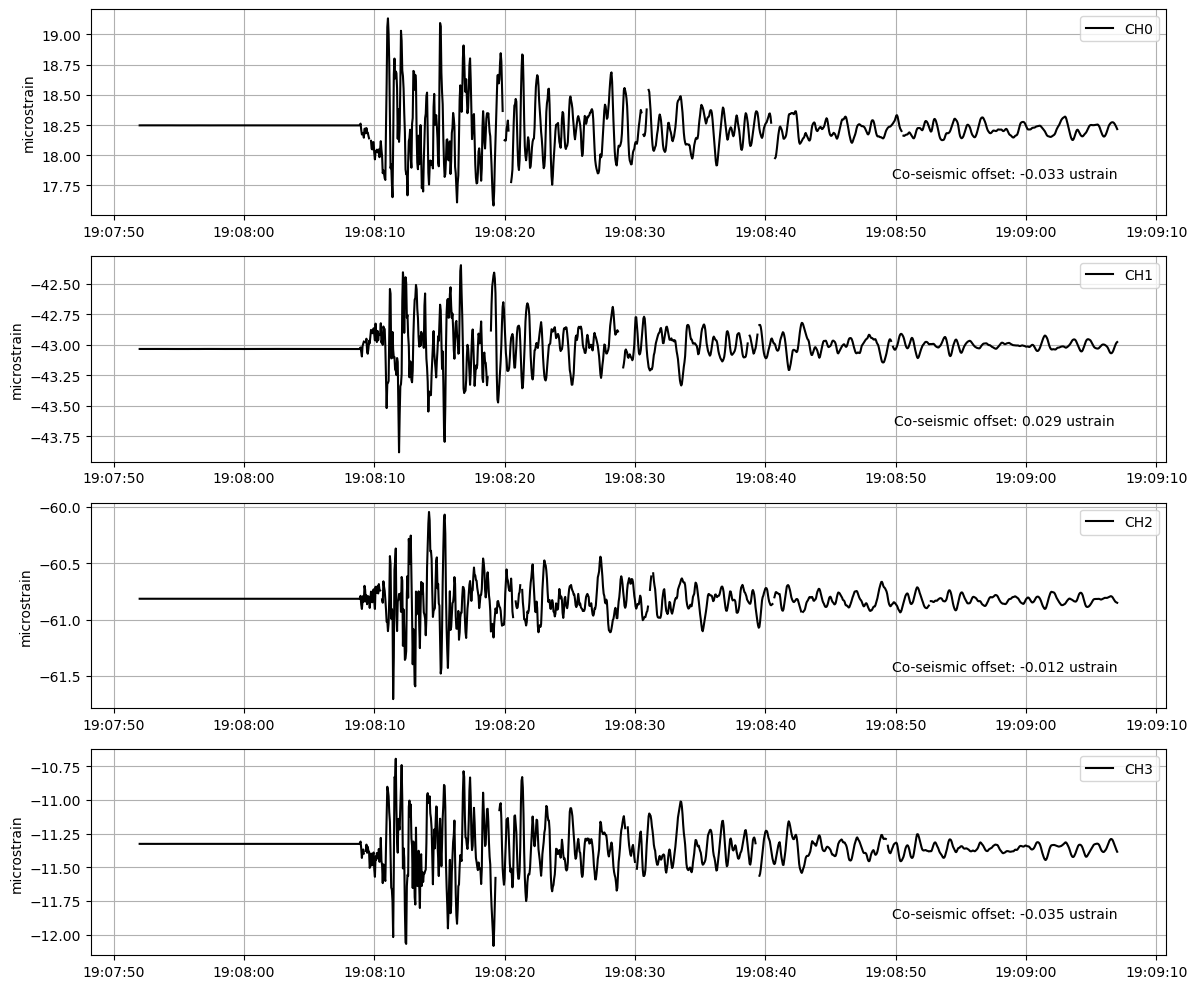

In [11]:
plot_coseismic_offset(
    df = ts2.data,
    plot_type='line',
    units = 'microstrain',
    eq_time= eq.time,
    coseismic_offset = True,
    color="black",)